# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

## Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

<font color="#3c8067">Car dealerships are frequently subjected to drastically varying customer demand based on a variety of factors, and their survival depends on their ability to understand what drives this demand. For owners, creating a viable and thriving business depends on an intimate understanding of the critical information driving more profitable sales and thus instigating higher vehicle churn on their lot. Understanding the key pieces of information that motivates a used car buyer to pull the trigger on a vehicle is critical to running a successful business. </font>

<font color="#3c8067">This problem can be formulated as a supervised multiple linear regression task. The objective is to model and quantify the relationship between vehicle attributes (e.g., mileage, age, make, model, condition, and geographic region) and used car sale price. By training a regression model on historical transaction data, the aim is to estimate model coefficients that quantify the marginal effect of each feature on price while controlling for other variables. The resulting model will generate price predictions and provide interpretable feature importance estimates to inform pricing strategy and inventory acquisition decisions. </font>


## Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

<font color="#3c8067">The vehicles dataset has numerous data types, and more than enough quantity to satisfy the modeling constraints. Initially, it is evident there is some data that isn't relevant to the problem statement: id and vin would be excellent as unique identifiers but have no bearing on our models accuracy due to their uniqueness. Other information, such as model of a vehicle, is too diverse to quantify in our model.</font>

<font color="#3c8067">Various portions of the data have missing values, so an assessment of how much data is missing and a subsequent trimming of the data to remove or fill in missing data will be needed. For example, vehicle size doesn't appear to have enough data to justify keeping in the analysis due to too many missing values.</font>

<font color="#3c8067">Some variables will be helpful but will need transformations from their string based scale to an ordinal encoding, including vehicle condition and title status.</font>

<font color="#3c8067">Other variables will be helpful if encoded nominally, including vehicle state, type, paint color, drive type, transmission, fuel, manufacturer and region.</font>

<font color="#3c8067">Finally, some data cleaning and modification is required. Data such as vehicle cylinders is captured as a string with the word "cylinders". This is unnecessary, so trimming is needed to transform this data into something usable by the model.</font>

## Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [209]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_extraction.text import CountVectorizer

#### Assess data for empty values, information types

In [210]:
v = pd.read_csv('data/vehicles.csv')
v.isna().sum()

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

#### Remove outliers in price data

In [211]:
v = v[(v['price'] >= 0) & (v['price'] <= 500000)]

#### Identify column types

In [212]:
numeric_cols = ['odometer', 'year']
ordinal_cols = ['condition', 'title_status']
categorical_cols = ['region', 'manufacturer', 'fuel', 'transmission', 'drive', 'type', 'paint_color']
custom_cols = ['cylinders']

#### Create mini pipeline to transform cylinders data format

In [213]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

def extract_cylinders(X):
    return X['cylinders'].str.extract(r'(\d+)').astype(float)

class FeatureNameFunctionTransformer(FunctionTransformer):
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return ['cylinders']
        return input_features

cylinders_transformer = FeatureNameFunctionTransformer(extract_cylinders, validate=False)

cylinders_pipeline = Pipeline(steps=[
    ('extract', cylinders_transformer),
    ('imputer', SimpleImputer(strategy='median', add_indicator=True))
])

#### Create mini pipeline to transform numeric columns

In [214]:
from sklearn.preprocessing import StandardScaler

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median', add_indicator=True)),
    ('scaler', StandardScaler()),
])

#### Create mini pipeline to transform ordinal columns

In [215]:
from sklearn.preprocessing import OrdinalEncoder

condition_values = ['new', 'like new', 'excellent', 'good', 'fair', 'salvage']
title_values = ['clean', 'lien', 'rebuilt', 'salvage', 'missing', 'parts only']
ordinal_categories = [condition_values, title_values]

ordinal_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=ordinal_categories))
])

#### Create mini pipeline to transform nominal columns

In [216]:
from sklearn.preprocessing import OneHotEncoder

nominal_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

#### Create transformer from pipelines

In [217]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('cyl', cylinders_pipeline, ['cylinders']),
        ('num', numeric_transformer, numeric_cols),
        ('ord', ordinal_transformer, ordinal_cols),
        ('nom', nominal_transformer, categorical_cols)
    ],
    remainder='drop'
)
# Drop unneeded columns: 'id', 'VIN', 'size', 'model', 'region'

## Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

#### Initialize test train data split

In [218]:
from sklearn.model_selection import train_test_split

v_X = v.drop(['price'], axis=1)
v_y = v['price']

v_X_train, v_X_test, v_y_train, v_y_test = train_test_split(v_X, v_y, test_size = 0.3, random_state = 42)

#### Visually demonstrate the need to log transform prices during modeling

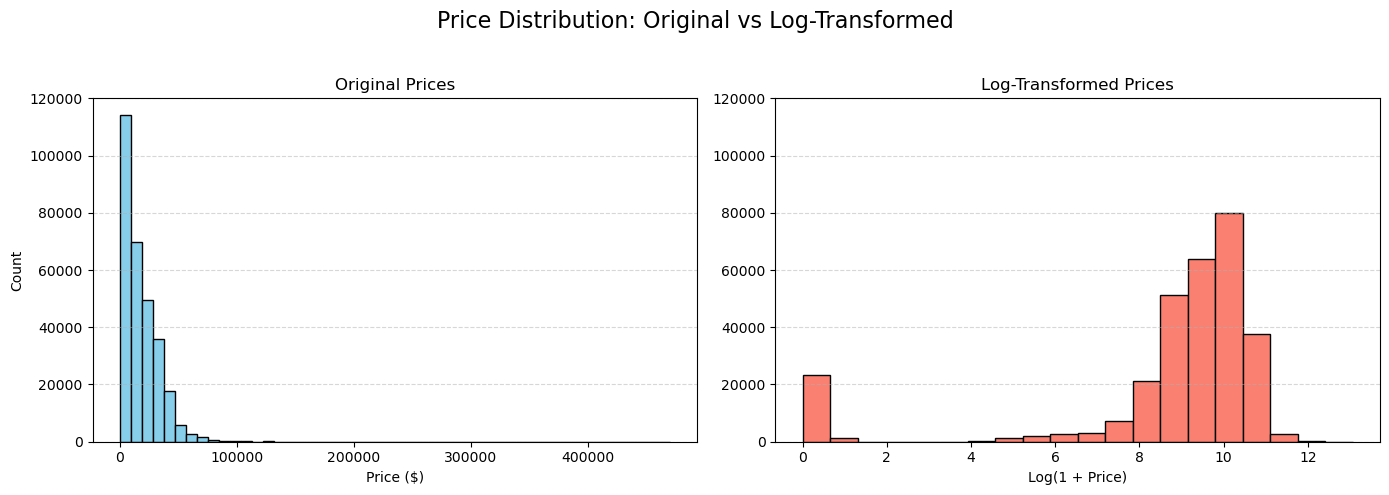

In [276]:
# Original and log-transformed prices
original_prices = v_y_train
log_prices = np.log1p(v_y_train)
ymax = max(original_prices.max(), log_prices.max()) + 50

fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Original prices histogram
axes[0].hist(original_prices, bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Original Prices')
axes[0].set_xlabel('Price ($)')
axes[0].set_ylabel('Count')
axes[0].set_ylim(0, 120000)
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# Log-transformed prices histogram
axes[1].hist(log_prices, bins=20, color='salmon', edgecolor='black')
axes[1].set_title('Log-Transformed Prices')
axes[1].set_xlabel('Log(1 + Price)')
axes[1].set_ylim(0, 120000)
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.suptitle("Price Distribution: Original vs Log-Transformed", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### Create function to compare different models

In [219]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import root_mean_squared_error as rmse
import numpy as np

def evaluate_model(model):
    # Create initial pipeline with preprocessing, scaling
    pipe = Pipeline([
        ('pre', preprocessor), 
        ('model', model)
    ])

    # Log transform to assist skewed price data
    log_pipe = TransformedTargetRegressor(
        regressor=pipe,
        func=np.log1p,
        inverse_func=np.expm1
    ).fit(v_X_train, v_y_train)

    # Capture optimized parameters if they exist
    fitted_model = log_pipe.regressor_.named_steps['model']

    params = {}
    for attr in ["alpha_", "l1_ratio_", "coef_"]:
        if hasattr(fitted_model, attr):
            params[attr] = getattr(fitted_model, attr)

    # Generate RMSE values for train, test data
    train_rmse = rmse(v_y_train, log_pipe.predict(v_X_train))
    test_rmse = rmse(v_y_test, log_pipe.predict(v_X_test))

    output = { 'pipe': log_pipe, 'params': params }

    return train_rmse, test_rmse, output

#### Utilize RMSE as a comparison metric

<span style="color:#3c8067">Usage of RMSE is helpful as this is measured in dollars ($) as opposed to mean squared error, which scales exponentially.</span>

In [220]:
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet

rmse_linreg_train, rmse_linreg_test, _ = evaluate_model(LinearRegression())
rmse_ridge_train, rmse_ridge_test, _ = evaluate_model(Ridge(alpha=1.0))
rmse_elasticnet_train, rmse_elasticnet_test, elasticnet_output = evaluate_model(ElasticNet(alpha=0.002, l1_ratio=0.17))

print("Linear Regression RMSE:")
print(f"Train: ${rmse_linreg_train:.2f}")
print(f"Test:  ${rmse_linreg_test:.2f}\n")

print("Ridge RMSE:")
print(f"Train: ${rmse_ridge_train:.2f}")
print(f"Test:  ${rmse_ridge_test:.2f}\n")

print("ElasticNet RMSE:")
print(f"Train: ${rmse_elasticnet_train:.2f}")
print(f"Test:  ${rmse_elasticnet_test:.2f}")

Linear Regression RMSE:
Train: $17617.47
Test:  $17732.59

Ridge RMSE:
Train: $17614.82
Test:  $17729.35

ElasticNet RMSE:
Train: $17396.00
Test:  $17461.67


#### Visual comparison of different modeling techniques and corresponding RMSE 

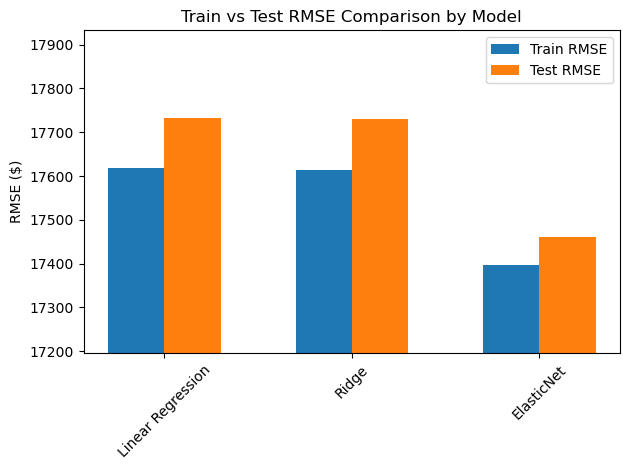

In [232]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ["Linear Regression", "Ridge", "ElasticNet"]
train_rmse = [rmse_linreg_train, rmse_ridge_train, rmse_elasticnet_train]
test_rmse = [rmse_linreg_test, rmse_ridge_test, rmse_elasticnet_test]

x = np.arange(len(models))
width = 0.3

plt.figure()

# Bars
plt.bar(x - width/2, train_rmse, width, label="Train RMSE")
plt.bar(x + width/2, test_rmse, width, label="Test RMSE")

# Labels and formatting
plt.xticks(x, models, rotation=45)
plt.ylabel("RMSE ($)")
plt.title("Train vs Test RMSE Comparison by Model")
plt.legend()

# Constrain y-axis to highlight differences
all_values = train_rmse + test_rmse
plt.ylim(min(all_values) - 200, max(all_values) + 200)

plt.tight_layout()
plt.show()

#### Tune ElasticNet model parameters to find best fit

In [278]:
from sklearn.linear_model import ElasticNetCV

elasticnet_cv = ElasticNetCV(
    l1_ratio=[0.16, 0.165, 0.17, 0.175],
    alphas=[0.001, 0.0015, 0.002, 0.0025],
    cv=3,
    max_iter=2000,
    n_jobs=-1
)

rmse_elasticnet_opt_train, rmse_elasticnet_opt_test, rmse_elasticnet_opt_output = evaluate_model(elasticnet_cv)

print("ElasticNet Cross Validation Hyperparameter Optimization & RMSE:")
print(f"Optimal Alpha: {rmse_elasticnet_opt_output['params']['alpha_']:.4f}")
print(f"Optimal L1 Ratio: {rmse_elasticnet_opt_output['params']['l1_ratio_']:.3f}")
print(f"Train: ${rmse_elasticnet_opt_train:.2f}")
print(f"Test:  ${rmse_elasticnet_opt_test:.2f}")

ElasticNet Cross Validation Hyperparameter Optimization & RMSE:
Optimal Alpha: 0.0010
Optimal L1 Ratio: 0.160
Train: $17406.98
Test:  $17476.23


#### Visualize ElasticNet Cross Validation hyperparameter tuning

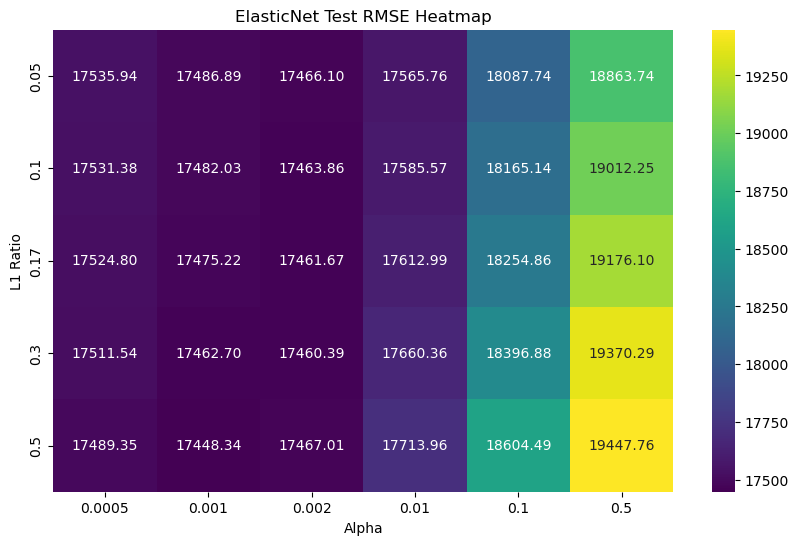

In [289]:
import seaborn as sns

alphas_all = [0.0005, 0.001, 0.002, 0.01, 0.1, 0.5]
l1_ratios_all = [0.05, 0.1, 0.17, 0.3, 0.5]

output = pd.DataFrame(index=l1_ratios_all, columns=alphas_all)

for l in l1_ratios_all:
    for a in alphas_all:
        _, rmse_test, _ = evaluate_model(ElasticNet(alpha=a, l1_ratio=l))
        output.loc[l, a] = float(rmse_test)

output = output.astype(float)

plt.figure(figsize=(10,6))
sns.heatmap(output, annot=True, fmt=".2f", cmap="viridis")
plt.xlabel("Alpha")
plt.ylabel("L1 Ratio")
plt.title("ElasticNet Test RMSE ($) Heatmap")
plt.show()

## Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

#### Defend accuracy of ElasticNet model against other model tests

In [233]:
best_rmse_ratio = rmse_elasticnet_train / rmse_elasticnet_test * 100
print(f'ElasticNet RMSE Ratio: {best_rmse_ratio:.1f}%')
print(f'ElasticNet RMSE Test/Train Difference: ${rmse_elasticnet_test - rmse_elasticnet_train:.0f}')

ElasticNet RMSE Ratio: 99.6%
ElasticNet RMSE Test/Train Difference: $66


<span style="color:#3c8067">The tuned ElasticNet model achieves a train RMSE of `$17,396` and a test RMSE of `$17,462`. The small difference of `$66` (~0.4% of RMSE) between training and test errors indicates that the model generalizes well and is not overfitting. Compared to a Linear Regression baseline (train/test RMSE `$17,617`/`$17,733`), ElasticNet improves predictive accuracy slightly while maintaining stability.</span>

#### Visualize accuracy of ElasticNet model in predicting prices

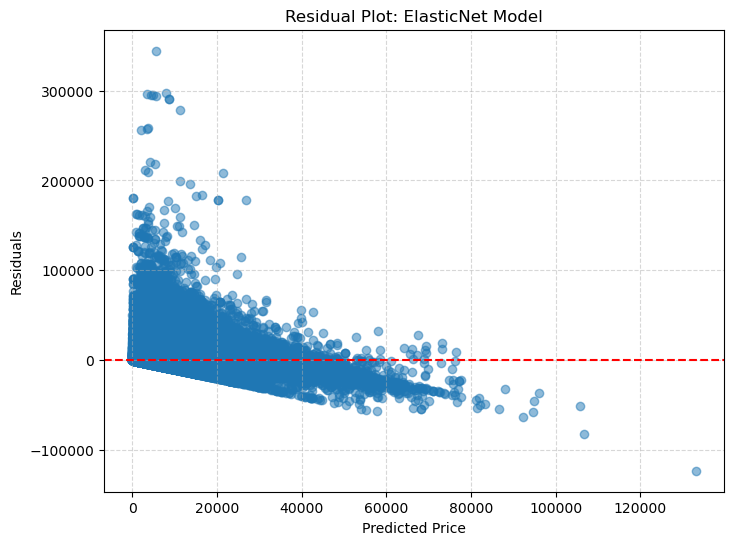

In [258]:
y_pred = elasticnet_output['pipe'].predict(v_X_test)

residuals = v_y_test - y_pred

plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residual Plot: ElasticNet Model")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

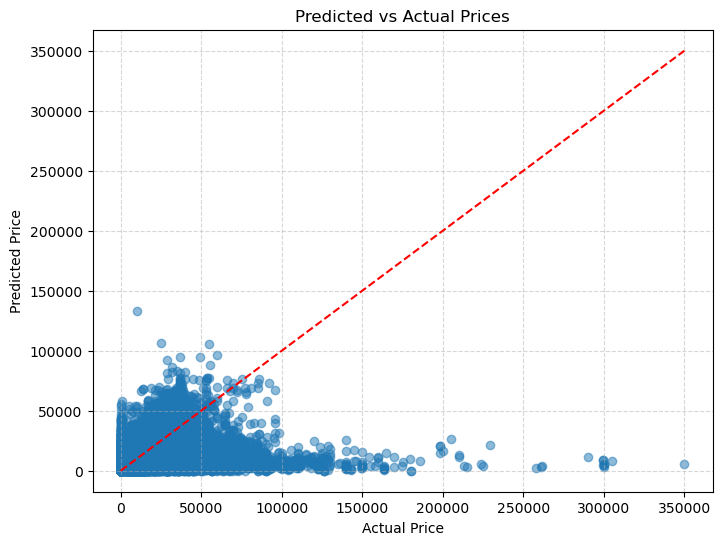

In [259]:
plt.figure(figsize=(8,6))
plt.scatter(v_y_test, y_pred, alpha=0.5)
plt.plot([v_y_test.min(), v_y_test.max()], [v_y_test.min(), v_y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Prices")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

#### Assess best performing data coefficients

In [234]:
# Extract feature names
fitted_preprocessor = elasticnet_output['pipe'].regressor_.named_steps['pre']
feature_names = fitted_preprocessor.get_feature_names_out()

# Get Coefficients
coefficients = elasticnet_output['params']['coef_']

# Store in dataframe
coefs = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
}).sort_values(by='coefficient', key=abs, ascending=False)

coefs.info()
coefs.head(20)

<class 'pandas.core.frame.DataFrame'>
Index: 496 entries, 304 to 495
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   feature      496 non-null    object 
 1   coefficient  496 non-null    float64
dtypes: float64(1), object(1)
memory usage: 11.6+ KB


,feature,coefficient
304,nom__region_salem,-1.452555
219,nom__region_medford-ashland,-1.313247
204,nom__region_long island,-1.278034
162,nom__region_inland empire,-1.262300
464,nom__transmission_other,1.053537
315,nom__region_santa maria,-1.024565
244,nom__region_norfolk / hampton roads,-1.010032
403,nom__region_winston-salem,-0.974265
122,nom__region_fort smith,-0.932060
373,nom__region_tulsa,-0.923144


#### Visualize most impactful data on the best model's predictions

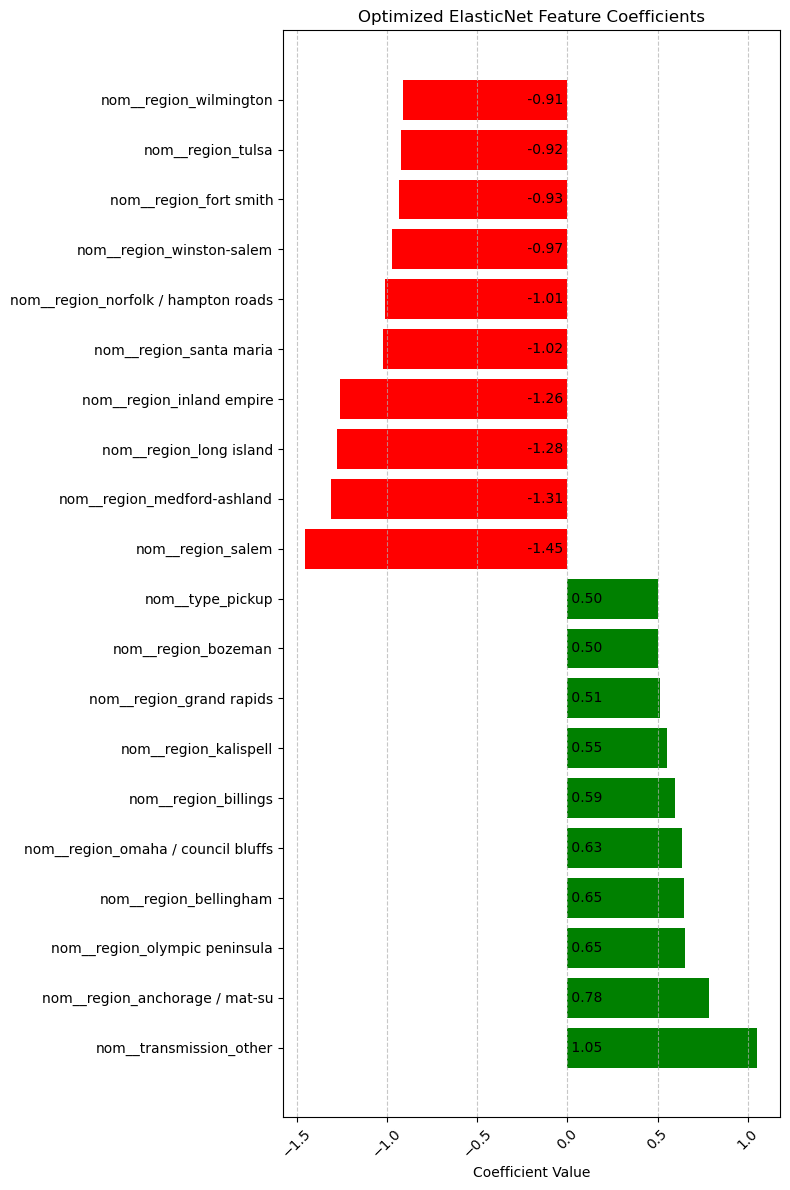

In [254]:
top_coefs = coefs.nlargest(10, 'coefficient')
bot_coefs = coefs.nsmallest(10, 'coefficient')
top_features = pd.concat([top_coefs, bot_coefs])
colors = ['green' if x > 0 else 'red' for x in top_features['coefficient']]

plt.figure(figsize=(8, 12))
bars = plt.barh(top_features['feature'], top_features['coefficient'], color=colors)
plt.xlabel("Coefficient Value")
plt.xticks(rotation=45)
plt.grid(axis='x', linestyle='--', alpha=0.7)

for bar in bars:
    width = bar.get_width()
    plt.text(
        x = (0.0 * max(top_features['coefficient'].abs())),
        y = bar.get_y() + bar.get_height()/2,
        s = f" {width:.2f} ",
        va = 'center',
        ha = 'left' if width > 0 else 'right'
    )

plt.title("Optimized ElasticNet Feature Coefficients")
plt.tight_layout()
plt.show()

#### Assess impactful coefficients excluding regional factors

In [229]:
non_region_coefs = coefs[~coefs['feature'].str.contains('region', na=False)]
non_region_coefs.head(10)

,feature,coefficient
464,nom__transmission_other,1.053537
478,nom__type_pickup,0.502205
423,nom__manufacturer_dodge,-0.477912
483,nom__paint_color_Unknown,-0.456114
416,nom__manufacturer_audi,0.432313
412,nom__manufacturer_Unknown,-0.413337
448,nom__manufacturer_rover,0.412898
446,nom__manufacturer_porsche,0.377480
434,nom__manufacturer_kia,-0.372382
432,nom__manufacturer_jaguar,0.361806


#### Visualize most impactful non-regional data on the best model's predictions

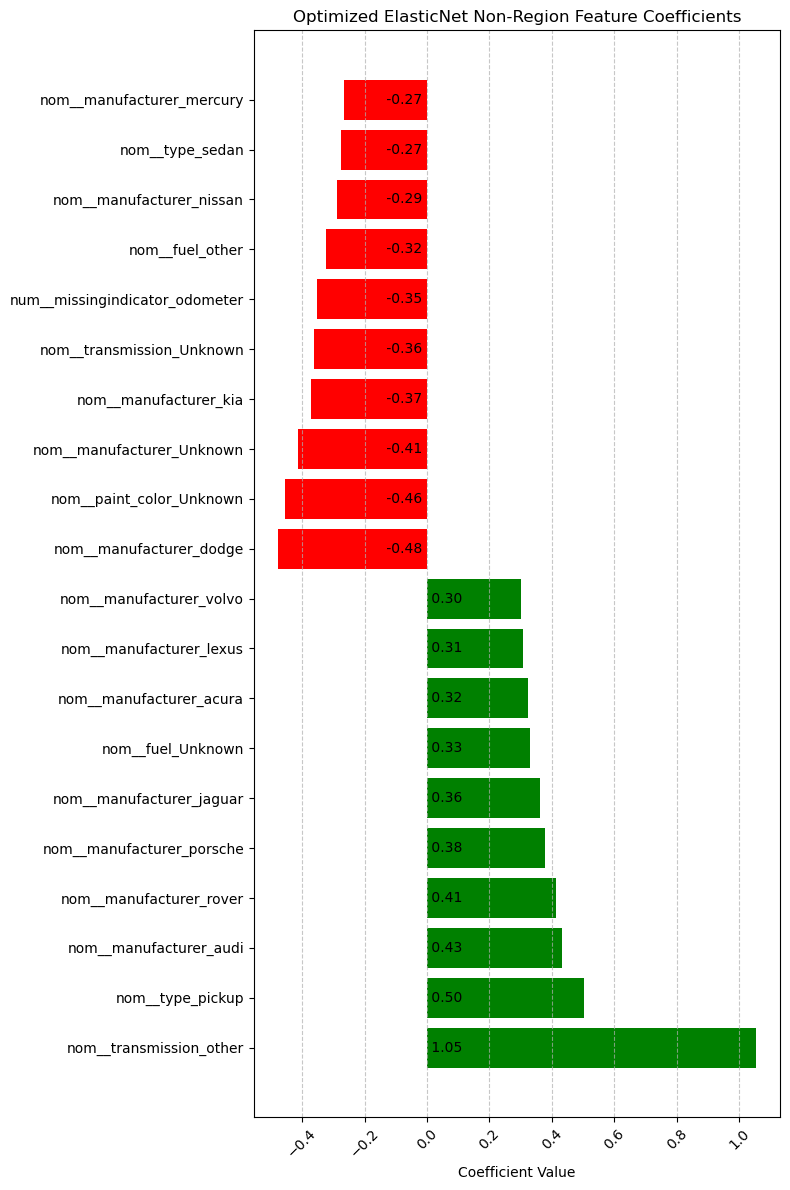

In [256]:
top_coefs = non_region_coefs.nlargest(10, 'coefficient')
bot_coefs = non_region_coefs.nsmallest(10, 'coefficient')
top_features = pd.concat([top_coefs, bot_coefs])
colors = ['green' if x > 0 else 'red' for x in top_features['coefficient']]

plt.figure(figsize=(8, 12))
bars = plt.barh(top_features['feature'], top_features['coefficient'], color=colors)
plt.xlabel("Coefficient Value")
plt.xticks(rotation=45)
plt.grid(axis='x', linestyle='--', alpha=0.7)

for bar in bars:
    width = bar.get_width()
    plt.text(
        x = (0.0 * max(top_features['coefficient'].abs())),
        y = bar.get_y() + bar.get_height()/2,
        s = f" {width:.2f} ",
        va = 'center',
        ha = 'left' if width > 0 else 'right'
    )

plt.title("Optimized ElasticNet Non-Region Feature Coefficients")
plt.tight_layout()
plt.show()

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

#### Findings and Opportunities

<span style="color:#3c8067">Our analysis has revealed a number of useful findings with regard to optimizing used cars sales throughput and profit margin. Of particular note, there are numerous geographic regions that negatively influence the price of vehicles sold there. These regions include Salem, Medford-Ashland, Long Island, among others. Vehicles acquired in these locations could present an opportunity if sold in higher-value markets, such as Anchorage/Mat-Su, Olympic Peninsula, and Bellingham, which tend to drive higher prices.</span>

<span style="color:#3c8067">Several car manufacturers were associated with higher resale prices, likely due to brand perception. These brands include Audi, Land Rover, Porsche, and Jaguar, among others. Additionally, pickup trucks generally commanded higher prices in the used car market.</span>

<span style="color:#3c8067">Vehicle characteristics that were correlated with lower sales prices included missing odometer readings, unknown transmission information, and unknown paint data. Certain brands were also associated with lower resale values, including Dodge, Kia, and Nissan. Overall, sedans performed worse on the used car market compared to other vehicle types.</span>

<span style="color:#3c8067">Other opportunities for further analysis were also identified. The transmission category “Other” and the fuel type “Unknown” were associated with higher-value sales; however, additional detailed data collection is needed to determine whether these links reflect a genuine trend or are artifacts of the dataset.</span>

#### Next Steps & Recommendations

<span style="color:#3c8067">
    
- Investigate the viability of acquistion, transport, and sale of vehicles from depressed markets, transport and sale in elevated markets
    
- Seek out pickup trucks for resale in all markets
  
- Seek out vehicles produced by Audi, Land Rover, Porsche, Jaguar, Acura, Lexus, and Volvo for resale in all markets
 
- Avoid deals involving Dodge, Kia, and Nissan
 
- Avoid deals involving sedans unless in excellent condition

- Avoid deals involving vehicles with broken odometers


- Avoid deals involving vehicles with unknown trasmission information</span>